In [1]:
# import required libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import string
from nltk.corpus import wordnet as wn

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = nltk.corpus.stopwords.words('english')


import gensim
from gensim.models import Word2Vec
from gensim.similarities import WmdSimilarity
import gensim.downloader as api

import re
import numpy as np
import pandas as pd

wpt = nltk.WordPunctTokenizer()
from sklearn.preprocessing import StandardScaler


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## words similarity

##### Approach 1: with WordNet

In [2]:
def preprocess_data(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Suppression des stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and not token in string.punctuation]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Reconstitution de la phrase prétraitée
    preprocessed_text = " ".join(tokens)
    
    return tokens

In [3]:
#test the process_data function
text = "This is an example sentence, showing off the stop words removal and lemmatization in NLTK."
preprocess_data(text)

['example',
 'sentence',
 'showing',
 'stop',
 'word',
 'removal',
 'lemmatization',
 'nltk']

In [4]:
def get_word_synsets(word):
    
    '''The function get_word_synsets retrieves the synsets (sets of synonyms)
        of a given word using the WordNet corpus from NLTK.'''
    
    synsets = wn.synsets(word)
    if synsets:
        return synsets
    else:
        return []

In [5]:
def compute_similarity(doc1, doc2):
    # Preprocess the documents
    words1 = preprocess_data(doc1)
    words2 = preprocess_data(doc2)
    
    
    similarity = 0

    # Iterate over each word in words1
    for word1 in words1:
        max_similarity = 0
         # Iterate over each word in words2
        for word2 in words2:

            # Get the synsets (sets of synonyms) for word1 and word2
            word1_synsets = get_word_synsets(word1)
            word2_synsets = get_word_synsets(word2)

             # Check if both words have synsets available
            if word1_synsets and word2_synsets:
                similarity_scores = []

                # Compare each synset of word1 with each synset of word2
                for synset1 in word1_synsets:
                    for synset2 in word2_synsets:

                        similarity_scores.append(synset1.path_similarity(synset2))

                # Find the maximum similarity score between synsets of word1 and word2        
                max_similarity = max(max_similarity, max(similarity_scores))

        # Accumulate the maximum similarity score for word1        
        similarity += max_similarity
        
    # Calculate the overall similarity by dividing the accumulated similarity by the average length of the two documents
    similarity /= (len(words1) + len(words2)) / 2
    
    return similarity


In [6]:
doc1="Regular exercise plays a crucial role in maintaining good physical and mental health. Engaging in activities like walking, jogging, or swimming can improve cardiovascular health, strengthen muscles, and enhance flexibility. Exercise also helps in managing weight, reducing the risk of chronic diseases such as diabetes and heart disease. Moreover, it promotes better sleep, boosts mood, and reduces stress and anxiety. It is recommended to incorporate at least 150 minutes of moderate-intensity exercise into your weekly routine for optimal health benefits."
doc2="Regular exercise plays a crucial role in maintaining good physical and mental health. Engaging in activities like walking, jogging, or swimming can improve cardiovascular health, strengthen muscles, and enhance flexibility. Exercise also helps in managing weight, reducing the risk of chronic diseases such as diabetes and heart disease. Moreover, it promotes better sleep, boosts mood, and reduces stress and anxiety. It is recommended to incorporate at least 150 minutes of moderate-intensity exercise into your weekly routine for optimal health benefits."
similarity_score = compute_similarity(doc1, doc2)
print("Similarity score:", similarity_score)

Similarity score: 0.9821428571428571


## Approach2: with word embedding & Word Mover’s Distance

In [7]:
# Download the pre-trained word embeddings
embedding_name = "glove-twitter-25"
embeddings_model = api.load(embedding_name)

In [8]:
def calculate_wmd(doc1,doc2):
    '''The function calculate_wmd calculates the Word 
    Mover's Distance (WMD) between two documents'''
    
    tokens1=preprocess_data(doc1)
    tokens2=preprocess_data(doc2)

    wmd_distance=embeddings_model.wmdistance(tokens1,tokens2)

    return wmd_distance


In [9]:
def calcul_similarity(doc1,doc2):
    distance = calculate_wmd(doc1, doc2)
    similarity = 1 / (1 + distance) 

    return similarity

In [10]:
similarity_score = calcul_similarity(doc1, doc2)
print("Similarity score:", similarity_score)

Similarity score: 1.0


## Word embedding with CBOW

##### From scratch:

In [11]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

CBOW architecture

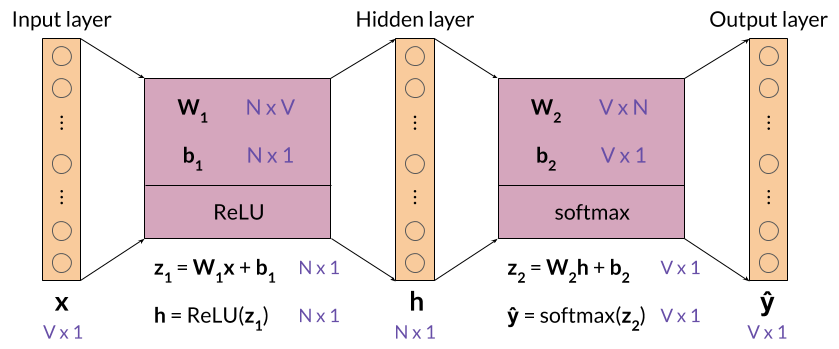

#### Data preparation

In [12]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

tokens= tokenize(text)

#### Sliding window of words

In [13]:
def get_windows(words, C):
    
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

In [14]:
#test the get_window function
for x, y in get_windows(
            ['machine',
 'learning',
 'is',
 'the',
 'study',
 'of',
 'computer',
 'algorithms'],
            2
        ):
    print(f'{x}\t{y}')

['machine', 'learning', 'the', 'study']	is
['learning', 'is', 'study', 'of']	the
['is', 'the', 'of', 'computer']	study
['the', 'study', 'computer', 'algorithms']	of


#### Transforming words into vectors for the training set

##### Mapping words to indices and indices to words


In [15]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [16]:
# test mapping function
word_to_id, id_to_word = mapping(tokens)


In [17]:
#test
print("Index of the word 'i':  ",word_to_id['machine'])

Index of the word 'i':   4


In [18]:
# vocabulary size
V = len(word_to_id)
print("Size of vocabulary: ", V)

Size of vocabulary:  60


#### Getting one-hot word vectors


In [19]:
def word_to_one_hot_vector(word, word_to_id, V):
    '''parameters: a word to be encoded, 
                   a dictionary that maps words to indices, 
                   and the size of the vocabulary.'''
    
    # create a vector with the size of the vocabulary, and fill it with zeros.
    one_hot_vector = np.zeros(V)

    # replace the 0 of the $n$-th element with a 1.
    one_hot_vector[word_to_id[word]] = 1
    return one_hot_vector

In [20]:
# Print output of 'word_to_one_hot_vector' function for word 'study'
word_to_one_hot_vector('study', word_to_id, V)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Getting context word vectors

In [21]:
def context_words_to_vector(context_words, word2Ind, V):
    context_words_vectors = [word_to_one_hot_vector(w, word_to_id, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    return context_words_vectors

In [22]:
# test
context_words_to_vector(['machine', 'learning', 'the', 'study'], word_to_id, V)

array([0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [23]:
# Print vectors associated to center and context words for corpus
for context_words, center_word in get_windows(tokens, 2):  # reminder: 2 is the context half-size
    print(f'Context words:  {context_words} -> {context_words_to_vector(context_words, word_to_id, V)}')
    print(f'Center word:  {center_word} -> {word_to_one_hot_vector(center_word, word_to_id, V)}')
    print()

Context words:  ['machine', 'learning', 'the', 'study'] -> [0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.
 0.   0.   0.   0.  ]
Center word:  is -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Context words:  ['learning', 'is', 'study', 'of'] -> [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.
 0.   0.   0.   0.  ]
Center word:  the -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [24]:
# Define the generator function 'get_training_example'
def get_training_example(tokens, C, word_to_id, V):
    for context_words, center_word in get_windows(tokens, C):

        #make  easier to iterate over a set of examples.
        yield context_words_to_vector(context_words, word_to_id, V), word_to_one_hot_vector(center_word, word_to_id, V)

The output of this function can be iterated on to get successive context word vectors and center word vectors, as demonstrated in the next cell.

In [25]:
# Print vectors associated to center and context words for corpus using the generator function
for context_words_vector, center_word_vector in get_training_example(tokens, 2, word_to_id, V):
    print(f'Context words vector:  {context_words_vector}')
    print(f'Center word vector:  {center_word_vector}')
    print()

Context words vector:  [0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.
 0.   0.   0.   0.  ]
Center word vector:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Context words vector:  [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.
 0.   0.   0.   0.  ]
Center word vector:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [26]:
training_examples = get_training_example(tokens, 2, word_to_id, V)

# Get first values from generator
x_array, y_array = next(training_examples)

Now convert these vectors into matrices (or 2D arrays) to be able to perform matrix multiplication on the right types of objects

In [27]:
# Copy vector
x = x_array.copy()

# Reshape it
x.shape = (V, 1)

# Print it
print(f'x:\n{x}\n')

# Copy vector
y = y_array.copy()

# Reshape it
y.shape = (V, 1)


x:
[[0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.25]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]



Activation functions

In [28]:
# Define the 'relu' function as seen in the previous lecture notebook
def relu(z):
    result = z.copy()
    result[result < 0] = 0
    return result

# Define the 'softmax' function as seen in the previous lecture notebook
def softmax(z):
    e_z = np.exp(z)
    sum_e_z = np.sum(e_z)
    return e_z / sum_e_z


In [29]:
# Define the size of the word embedding vectors and save it in the variable 'n_embedding'
n_embedding = 3

#### Initialization of the weights and biases

In [30]:
np.random.seed(42)
W1= np.random.randn(n_embedding,V)
b1=np.random.rand(n_embedding,1)
W2= np.random.randn(V,n_embedding)
b2=np.random.rand(V,1)

### Values of the hidden layer

Now that we have initialized all the variables that we need for forward propagation, we can calculate the values of the hidden layer using the following formulas:

\begin{align}
 \mathbf{z_1} = \mathbf{W_1}\mathbf{x} + \mathbf{b_1}  \tag{1} \\
 \mathbf{h} = \mathrm{ReLU}(\mathbf{z_1})  \tag{2} \\
\end{align}

First, we can calculate the value of $\mathbf{z_1}$.

In [31]:
# Compute z1 (values of first hidden layer before applying the ReLU function)
z1 = np.dot(W1, x) + b1
# Compute h (z1 after applying ReLU function)
h = relu(z1)

### Values of the output layer

to calculate the values of the output layer, represented by the vector $\mathbf{\hat y}$, we use:

\begin{align}
 \mathbf{z_2} &= \mathbf{W_2}\mathbf{h} + \mathbf{b_2}   \tag{3} \\
 \mathbf{\hat y} &= \mathrm{softmax}(\mathbf{z_2})   \tag{4} \\
\end{align}

**First, calculate $\mathbf{z_2}$.**

In [32]:
# Compute z2 (values of the output layer before applying the softmax function)
z2 = np.dot(W2, h) + b2

# Compute y_hat (z2 after applying softmax function)
y_hat = softmax(z2)

#### Cross-entropy loss

determine how accurate the prediction was compared to the actual target.


The formula for cross-entropy loss is:

$$ J=-\sum\limits_{k=1}^{V}y_k\log{\hat{y}_k} \tag{6}$$



In [33]:
def cross_entropy_loss(y_predicted, y_actual):
    # Fill the loss variable with your code
    loss = np.sum(-np.log(y_predicted)*y_actual)
    return loss

In [34]:
cross_entropy_loss(y_hat, y)

5.2539674094192055



## Backpropagation

The formulas that we will implement for backpropagation are the following.

\begin{align}
 \frac{\partial J}{\partial \mathbf{W_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right )\mathbf{x}^\top \tag{7}\\
 \frac{\partial J}{\partial \mathbf{W_2}} &= (\mathbf{\hat{y}} - \mathbf{y})\mathbf{h^\top} \tag{8}\\
 \frac{\partial J}{\partial \mathbf{b_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right ) \tag{9}\\
 \frac{\partial J}{\partial \mathbf{b_2}} &= \mathbf{\hat{y}} - \mathbf{y} \tag{10}
\end{align}




In [35]:
# Compute vector with partial derivatives of loss function with respect to b2
grad_b2 = y_hat - y

# Compute matrix with partial derivatives of loss function with respect to W2
grad_W2 = np.dot(y_hat - y, h.T)

# Compute vector with partial derivatives of loss function with respect to b1
grad_b1 = relu(np.dot(W2.T, y_hat - y))

# Compute matrix with partial derivatives of loss function with respect to W1
grad_W1 = np.dot(relu(np.dot(W2.T, y_hat - y)), x.T)

In [36]:
print(f'V (vocabulary size): {V}')
print(f'N (embedding size / size of the hidden layer): {n_embedding}')
print(f'size of grad_W1: {grad_W1.shape} (NxV)')
print(f'size of grad_b1: {grad_b1.shape} (Nx1)')
print(f'size of grad_W2: {grad_W2.shape} (VxN)')
print(f'size of grad_b2: {grad_b2.shape} (Vx1)')

V (vocabulary size): 60
N (embedding size / size of the hidden layer): 3
size of grad_W1: (3, 60) (NxV)
size of grad_b1: (3, 1) (Nx1)
size of grad_W2: (60, 3) (VxN)
size of grad_b2: (60, 1) (Vx1)


## Gradient descent

During the gradient descent phase, you will update the weights and biases by subtracting $\alpha$ times the gradient from the original matrices and vectors, using the following formulas.

\begin{align}
 \mathbf{W_1} &:= \mathbf{W_1} - \alpha \frac{\partial J}{\partial \mathbf{W_1}} \tag{11}\\
 \mathbf{W_2} &:= \mathbf{W_2} - \alpha \frac{\partial J}{\partial \mathbf{W_2}} \tag{12}\\
 \mathbf{b_1} &:= \mathbf{b_1} - \alpha \frac{\partial J}{\partial \mathbf{b_1}} \tag{13}\\
 \mathbf{b_2} &:= \mathbf{b_2} - \alpha \frac{\partial J}{\partial \mathbf{b_2}} \tag{14}\\
\end{align}


In [37]:
# Define alpha
alpha = 0.03

# Compute updated W1
W1_new = W1 - alpha * grad_W1

# Compute updated W2
W2_new = W2 - alpha * grad_W2

# Compute updated b1
b1_new = b1 - alpha * grad_b1

# Compute updated b2
b2_new = b2 - alpha * grad_b2

In [38]:
W1.shape

(3, 60)

In [39]:
# Loop through each word of the vocabulary
for word in word_to_id:
    # Extract the column corresponding to the index of the word in the vocabulary
    word_embedding_vector = W1[:, word_to_id[word]]
    # Print word alongside word embedding vector
    print(f'Word: {word} | Embedding: {word_embedding_vector}')


Word: of | Embedding: [ 0.49671415 -0.47917424  0.79103195]
Word: through | Embedding: [-0.1382643  -0.18565898 -0.90938745]
Word: tasks | Embedding: [ 0.64768854 -1.10633497  1.40279431]
Word: a | Embedding: [ 1.52302986 -1.19620662 -1.40185106]
Word: machine | Embedding: [-0.23415337  0.81252582  0.58685709]
Word: training | Embedding: [-0.23413696  1.35624003  2.19045563]
Word: algorithms | Embedding: [ 1.57921282 -0.07201012 -0.99053633]
Word: perform | Embedding: [ 0.76743473  1.0035329  -0.56629773]
Word: make | Embedding: [-0.46947439  0.36163603  0.09965137]
Word: infeasible | Embedding: [ 0.54256004 -0.64511975 -0.50347565]
Word: variety | Embedding: [-0.46341769  0.36139561 -1.55066343]
Word: artificial | Embedding: [-0.46572975  1.53803657  0.06856297]
Word: do | Embedding: [ 0.24196227 -0.03582604 -1.06230371]
Word: build | Embedding: [-1.91328024  1.56464366  0.47359243]
Word: automatically | Embedding: [-1.72491783 -2.6197451  -0.91942423]
Word: to | Embedding: [-0.562287

##### using gensim

In [40]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove all punctuation
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    
    #remove any digits (numbers)
    text = re.sub(r'\d+', '', text)
    
    return text


In [41]:
# Tokenize into sentences
sentences = sent_tokenize(text)
text=preprocess(text)
# Tokenize the sentences into words
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

In [42]:
# train the Model
model = Word2Vec(tokenized_sentences,vector_size=3, window=5,min_count=1,sg=0)

# Obtenir tous les mots du vocabulaire
words = list(model.wv.key_to_index.keys())

# Afficher chaque mot avec son embedding
for word in words:
    embedding = model.wv.get_vector(word)
    print(f'Word: {word} | Embedding: {embedding}')


Word: . | Embedding: [-0.01787424  0.00788105  0.17011166]
Word: to | Embedding: [ 0.30019328 -0.3115975  -0.23645042]
Word: algorithms | Embedding: [ 0.2149941   0.2985288  -0.16695288]
Word: , | Embedding: [-0.1254006   0.24475677 -0.05086717]
Word: machine | Embedding: [-0.15153104  0.21755512 -0.16200581]
Word: learning | Embedding: [-0.0605833   0.0947827   0.03317054]
Word: is | Embedding: [-0.27607957 -0.31564498  0.24397875]
Word: of | Embedding: [0.16900873 0.22525644 0.02542885]
Word: a | Embedding: [ 0.21164015 -0.11510277 -0.03076098]
Word: as | Embedding: [ 0.19207078 -0.25213814 -0.13087903]
Word: in | Embedding: [-0.25053084 -0.03176463  0.31792405]
Word: or | Embedding: [-0.24378148 -0.07828728 -0.06436103]
Word: it | Embedding: [ 0.26936173 -0.19787991  0.00153247]
Word: data | Embedding: [-0.15830922 -0.320434    0.16695641]
Word: the | Embedding: [-0.29163316 -0.14690854 -0.001092  ]
Word: computer | Embedding: [-0.00973364 -0.25581473  0.32075828]
Word: experience |

## Sentiment Analysis wwith word2vec & Logistic Regression

In [43]:
class LogisticRegression:
    
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        '''The LogisticRegression class represents a logistic regression model. It has two parameters:
      learning_rate (default value of 0.01) and num_iterations (default value of 1000). 
      These parameters control the learning rate and the number of iterations for gradient descent optimization.
      The weights and bias are initialized as None. These variables will store the coefficients learned by the model.
      The scaler object is an instance of StandardScaler from scikit-learn, used for feature scaling.'''
        
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.scaler = StandardScaler()  # StandardScaler for feature scaling

    def sigmoid(self, z):
        '''The sigmoid function implements the sigmoid activation function, which maps any real value to the range [0, 1].'''
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Scale the features
        X = self.scaler.fit_transform(X)

        # Gradient descent optimization
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # Scale the features
        X = self.scaler.transform(X)
        
        # Predict the probability of the positive class
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        
        # Convert probability to class labels
        y_pred_class = np.where(y_pred > 0.5, 1, 0)
        return y_pred_class

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy


In [44]:
# read data 
data = pd.read_csv('tweets.csv')
data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [45]:
# calculate the number of missing values
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

Data Preprocessing

In [46]:
def tweet_cleaner(text):
    
    # Remove hashtags
    new_text = re.sub("#", "", text)
    # Remove Twitter usernames starting with @
    new_text = re.sub("@[A-Za-z0-9]+", "", new_text)
    # Remove URLs starting with http:// or https://
    new_text = re.sub(r"http\S+", "", new_text)
    # Remove non-alphabet characters and replace with a space
    new_text = re.sub(r"[^a-zA-Z]", " ", new_text)
     # Convert text to lowercase and remove leading/trailing whitespace    
    new_text = new_text.lower().strip()
    
    cleaned_text = ''
    for token in new_text.split(): 
          lemmatizer = WordNetLemmatizer()
          cleaned_text = cleaned_text + lemmatizer.lemmatize(token) + ' '
    
    return cleaned_text

In [47]:
# list to store cleaned tweets
cleaned_tweets = []  
for twt in data['tweet']:
    cleaned_tweets.append(tweet_cleaner(twt))

In [48]:
# assigns the list of cleaned tweets (cleaned_tweets) as a new column named 'cleaned_tweets' in the data DataFrame.
data['cleaned_tweets'] = cleaned_tweets
data.head()

,id,label,tweet,cleaned_tweets
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to m...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this would you go talk makememories un...
3,4,0,I'm wired I know I'm George I was made that wa...,i m wired i know i m george i wa made that way...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple won t even talk to ...


In [49]:
data.iloc[0].label, data.iloc[0].cleaned_tweets,

(0,
 'fingerprint pregnancy test android apps beautiful cute health igers iphoneonly iphonesia iphone ')

In [50]:
tweets_list = list(data['cleaned_tweets'].apply(lambda x: x.split()))
tweets_list[0] # list of lists, where each tweet is a list of tokens, finally we have a list of tweets

['fingerprint',
 'pregnancy',
 'test',
 'android',
 'apps',
 'beautiful',
 'cute',
 'health',
 'igers',
 'iphoneonly',
 'iphonesia',
 'iphone']

Word2Vec Model Training on Tweets for Word Embeddings

In [51]:
# train model
cbow_model = Word2Vec(tweets_list, vector_size = 100, window = 5, min_count=5, sg=0)

In [52]:
cbow_model.save("cbow_model.model")
len(cbow_model.wv.index_to_key)

2451

Document Vector Creation using Word2Vec Word Embeddings

In [53]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    
    # doc1 contains those words of the document which are included in the Word2Vec model's vocabulary
    doc1 = [word for word in doc.split() if word in cbow_model.wv.index_to_key]#filters out the words that are not present in the Word2Vec model's vocabulary 
    
    wv1 = []  # this will contain the WE of all the vocab words from the doc

    # iterates over each word in doc1 and retrieves the corresponding word vector
    for word in doc1:
        wv1.append(cbow_model.wv.get_vector(word))

    # converted to a NumPy array    
    wv1_ = np.array(wv1)
    # the mean of the word vectors along the 0-axis 
    wv1_mean = wv1_.mean(axis=0)

    #return the average document vector
    return wv1_mean

Document Vector Generation for Cleaned Tweets

In [54]:
tweets_temp = data['cleaned_tweets'].apply(document_vector)

Combining Document Vectors into a Feature Matrix

In [55]:
# Combining all the document vectors into a single numpy array (tweets_vec)
embedding_size = 100


tweets_vec = np.ones((len(tweets_temp), embedding_size))*np.nan

for i in range(tweets_vec.shape[0]):
    # assigns the document vector to the i-th row of tweets_vec.
    tweets_vec[i,:] = tweets_temp.iloc[i]

# tweets_vec.shape represents the shape of the final feature matrix
tweets_vec.shape 

(7920, 100)

In [64]:
# Create a new DataFrame to store the new document features
df = pd.DataFrame(tweets_vec)

# Assign the 'label' column from the original data to the new DataFrame
df['y'] = data['label']

# Remove rows with any NaN values from the DataFrame
df.dropna(how='any', axis=0, inplace=True)


In [57]:
X_word_emb = df.drop('y',axis=1)
y = df['y']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_word_emb, y,test_size=0.25, random_state=0)

Logistic Regression Model Training

In [59]:
lr = LogisticRegression(learning_rate=0.01, num_iterations=1000)
lr.fit(X_train, y_train)

Prediction using Logistic Regression Model

In [60]:
y_pred=lr.predict(X_test)

Classification Metrics for Logistic Regression Model

In [62]:
print(lr.score(X_train, y_train))  # train score)
print(lr.score(X_test, y_test))   # test score)  

0.8526936026936027
0.8641414141414141


Usage: Sentiment Prediction 

In [63]:
def preprocess_text(text):
    cleaned_text = tweet_cleaner(text)  # Apply the same preprocessing steps as during training
    doc_vector = document_vector(cleaned_text)  # Convert the preprocessed text to a document vector
    return doc_vector

# Example usag
new_text ="I can't believe how disappointed I am with the service at this restaurant. The food was cold, the staff was rude, and the overall experience was terrible. Definitely never coming back here again! #worstservice #terribleexperience"

# Preprocess the new text
cleaned_text = preprocess_text(new_text)
preprocessed_text = cleaned_text.reshape(1, -1)

# Make predictions using the logistic regression model
prediction = lr.predict(preprocessed_text)

# Print the predicted sentiment
if prediction == 0:
    print("Positive sentiment ")
else:
    print("Negative sentiment ")



Negative sentiment 
